# SENTENCE PAIRS CLASSIFICATION: GLOVE IMPLEMENTATION

### 1. DATA EXPLORATION

In [2]:
import numpy as np
import pandas as pd
import csv

# Import packages for pre-processing
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Packages for pretrained glove and tfidf
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Cosine Similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

# Data Modelling
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Download packages
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# Download dataset
!wget "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
# Extract
!unzip "./snli_1.0.zip" -d "data"

--2021-11-30 07:42:37--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  9.56MB/s    in 6.3s    

2021-11-30 07:42:44 (14.3 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  ./snli_1.0.zip
   creating: data/snli_1.0/
  inflating: data/snli_1.0/.DS_Store  
   creating: data/__MACOSX/
   creating: data/__MACOSX/snli_1.0/
  inflating: data/__MACOSX/snli_1.0/._.DS_Store  
 extracting: data/snli_1.0/Icon      
  inflating: data/__MACOSX/snli_1.0/._Icon  
  inflating: data/snli_1.0/README.txt  
  inflating: data/__MACOSX/snli_1.0/._README.txt  
  inflating: data/snli_1.0/snli_1.0_dev.jsonl  
  inflating: data/snli_1.0/snli_1.0_dev.txt  
  inflating: data/snli_1.0/snl

In [5]:
# Load the SNLI dataset

path = './data/snli_1.0/'
train_data = pd.read_csv(path + 'snli_1.0_train.txt', sep="\t")
train_data = pd.DataFrame(train_data, columns=['sentence1', 'sentence2', 'gold_label'])

# Remove all the rows labeled as '-' and NaN values
train_data = train_data.loc[train_data['gold_label'] != '-']
train_data = train_data.dropna()

# Create a subset of the data in order to run de model faster
train_data = train_data.iloc[:10000,:]
train_data.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [6]:
# Test set
test_data = pd.read_csv(path + 'snli_1.0_test.txt', sep="\t")
test_data = pd.DataFrame(test_data, columns=['sentence1', 'sentence2', 'gold_label'])

# Remove all the rows labeled as '-' and NaN values
test_data = test_data.loc[test_data['gold_label'] != '-']
test_data = test_data.dropna()

# Create a subset of the data in order to run de model faster
test_data = test_data.iloc[:2500,:]
test_data.head()

,sentence1,sentence2,gold_label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment


In [7]:
# Shuffle data
train_data = train_data.sample(frac=1, random_state=203)

# Size of the datasets 
print('Train Data size:', train_data.shape)
print('Test Data size:', test_data.shape)

Train Data size: (10000, 3)
Test Data size: (2500, 3)


In [8]:
# Labels distributions
print('==Labels train set:==\n{}'.format(train_data['gold_label'].value_counts()))
print('\n==Labels test set:==\n{}'.format(test_data['gold_label'].value_counts()))

==Labels train set:==
entailment       3340
contradiction    3334
neutral          3326
Name: gold_label, dtype: int64

==Labels test set:==
entailment       854
neutral          830
contradiction    816
Name: gold_label, dtype: int64


### 2. DATA PRE-PROCESSING

In [9]:
lemmat = WordNetLemmatizer()

def clean_text(sentence, lemma=False):    

    # Step 1: Transform text to lower case, remove url, some punctuations and long repeated characters 
    sent = sentence.lower()
    sent = re.sub(r'(http:)\S+', r'', sent)
    sent = re.sub(r'[\.,`=_/#]', r' ', sent)
    sent = re.sub(r'(\w)\1{2,}', r'\1\1', sent)

    # Step 2: Find the tokens of each text and apply lemmatization
    tokens = word_tokenize(sent)
    if lemma: tokens = [lemmat.lemmatize(w) for w in tokens] 

    return ' '.join(tokens)

# Data Cleaning in both sets
train_data['clean_sent1'] = train_data['sentence1'].map(lambda x: clean_text(x, lemma=True))
train_data['clean_sent2'] = train_data['sentence2'].map(lambda x: clean_text(x, lemma=True))

test_data['clean_sent1'] = test_data['sentence1'].map(lambda x: clean_text(x, lemma=True))
test_data['clean_sent2'] = test_data['sentence2'].map(lambda x: clean_text(x, lemma=True))

In [10]:
# Column with integer labels
dict_label = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
train_data['int_label'] = train_data['gold_label'].map(lambda x: dict_label[x])
test_data['int_label'] = test_data['gold_label'].map(lambda x: dict_label[x])

In [11]:
# Preview results after pre-processing
train_data.iloc[:3]

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label
4638,Two small children playing football in yellow ...,two small children are playing football for th...,neutral,two small child playing football in yellow and...,two small child are playing football for their...,1
3472,Two asian females go walking.,The females are moving their legs.,entailment,two asian female go walking,the female are moving their leg,0
8723,A girl walking near a guy holding onto a bike ...,Two kids are riding mopeds.,contradiction,a girl walking near a guy holding onto a bike ...,two kid are riding moped,2


### 3. TEXT VECTORIZATION

In [12]:
# Download glove vectors
!wget "https://nlp.stanford.edu/data/glove.6B.zip"
# Extract
!unzip "glove.6B.zip" -d "data"

--2021-11-30 07:43:01--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-30 07:43:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.74MB/s    in 2m 48s  

2021-11-30 07:45:50 (4.88 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: data/glove.6B.50d.txt   
  inflating: data/glove.6B.100d.txt  
  inflating: 

In [13]:
# Loading the 300-dimension vectors
path = "data/glove.6B.300d.txt"

#glove_file = datapath(path)
glove_vec_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(path, glove_vec_file)
word_vectors = KeyedVectors.load_word2vec_format(glove_vec_file)

In [14]:
# Size of the data vocabulary
all_sent = np.concatenate([train_data['clean_sent1'].values,train_data['clean_sent2'].values], axis=0)
words = []
for i in all_sent:
    tokens = word_tokenize(i.lower())
    words.extend(tokens)    
vocab = list(set(words))

print('Size of the data vocab:', len(vocab))

# Size of the GloVe vocabulary
print("Size of GloVe's vocab:", len(list(word_vectors.vocab)))

# Number of words out of the GloVe vocabulary (OOV)
out_vocab = []
for i in vocab:
    if i in word_vectors.vocab: continue
    out_vocab.append(i)
print('Number of OOV:', round(len(out_vocab)/len(vocab),2))


Size of the data vocab: 5132
Size of GloVe's vocab: 400000
Number of OOV: 0.04


In [15]:
# Compute the embedding of a sentence by computing the average embedding of contained words
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in sent.split():
        if token not in word_vectors: continue
        else:
            word_vecs.append(word_vectors[token])

    return np.mean(np.array(word_vecs),axis=0)

In [16]:
# Vectorize the sentences
X_train1 = np.array([vectorize_sent(word_vectors, sent) for sent in train_data['clean_sent1'].values])
X_train2 = np.array([vectorize_sent(word_vectors, sent) for sent in train_data['clean_sent2'].values])

X_test1 = np.array([vectorize_sent(word_vectors, sent) for sent in test_data['clean_sent1'].values])
X_test2 = np.array([vectorize_sent(word_vectors, sent) for sent in test_data['clean_sent2'].values])

In [17]:
print(X_train1.shape, X_train2.shape, X_test1.shape, X_test2.shape)

(10000, 300) (10000, 300) (2500, 300) (2500, 300)


### 4. SENTENCE SIMILARITY

In [18]:
# Create a Dictionary of labels with its cosine values
def dic_labels(x,y):
    
    dic = {
    'neutral': [],
    'entailment': [],
    'contradiction': []
    }
    
    for i,j in zip(x,y):
        if j == 'entailment':
            dic[j].append(i)
        elif j == 'neutral':
            dic[j].append(i)
        else:
            dic[j].append(i)
    
    return dic

In [19]:
# Compute distance metrics
cosine = lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
euclidean = lambda x,y: euclidean_distances(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]

train_data['dist_cos'] = list(map(cosine, X_train1, X_train2))
train_data['dist_euc'] = list(map(euclidean, X_train1, X_train2))

dist_cos = dic_labels(train_data['dist_cos'].values, train_data['gold_label'].values)
dist_euc = dic_labels(train_data['dist_euc'].values, train_data['gold_label'].values)

In [20]:
train_data.iloc[:5]

,sentence1,sentence2,gold_label,clean_sent1,clean_sent2,int_label,dist_cos,dist_euc
4638,Two small children playing football in yellow ...,two small children are playing football for th...,neutral,two small child playing football in yellow and...,two small child are playing football for their...,1,0.840819,2.261548
3472,Two asian females go walking.,The females are moving their legs.,entailment,two asian female go walking,the female are moving their leg,0,0.813364,2.440572
8723,A girl walking near a guy holding onto a bike ...,Two kids are riding mopeds.,contradiction,a girl walking near a guy holding onto a bike ...,two kid are riding moped,2,0.661259,2.913282
341,A man squatting in the foreground of a photogr...,A male skateboarder performs tricks outdoors f...,neutral,a man squatting in the foreground of a photogr...,a male skateboarder performs trick outdoors fo...,1,0.680849,2.531323
703,A man carrying a load of fresh direct boxes on...,A young lad delivers groceries by bicycle in t...,contradiction,a man carrying a load of fresh direct box on c...,a young lad delivers grocery by bicycle in the...,2,0.860120,1.836156


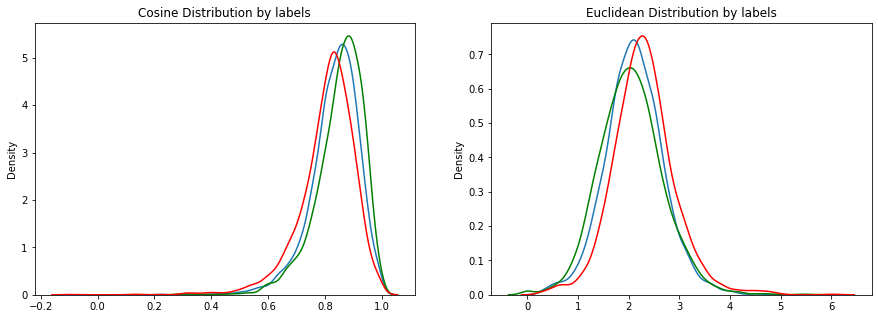

In [21]:
# Cosine scores distribution by labels
metric = ['Cosine', 'Euclidean']
results = [dist_cos, dist_euc]
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(0,2):
    sb.distplot(results[i]['neutral'], hist=False, ax=ax[i])
    sb.distplot(results[i]['entailment'], hist=False, color='green', ax=ax[i])
    sb.distplot(results[i]['contradiction'], hist=False, color='red', ax=ax[i])
    ax[i].set_title(metric[i] + ' Distribution by labels')

plt.show()


## 5. DATA MODELING. MULTI-CLASSIFICATION PROBLEM

In [22]:
# The approach used to represent the input is going to be subtraction (A sent_vector - B sent_vector)
X_train = []
for i in range(0,len(X_train1)):
    subs = X_train1[i] - X_train2[i]
    X_train.append(subs)
    
X_test = []
for i in range(0,len(X_test1)):
    subs = X_test1[i] - X_test2[i]
    X_test.append(subs)

y_train = np.array(train_data['int_label'])
y_test = np.array(test_data['int_label'])

print('X_train Shape:', len(X_train))
print('y_train Shape:', y_train.shape)

X_train Shape: 10000
y_train Shape: (10000,)


In [23]:
class EstimatorSelectionHelper:
    
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys() # list of models' names
        self.grid_searches = {} ## empty dictionary for the Grid.fit of each model
    
    def fit(self, X, y, **grid_kwargs):
        for key in self.keys:
            print('Running GridSearchCV for %s.' % key)
            model = self.models[key]
            params = self.params[key]
            grid_search = GridSearchCV(model, params, **grid_kwargs, cv=3)
            grid_search.fit(X, y)
            self.grid_searches[key] = grid_search ## fitting output from gird_search
        print('Done.')
    
    def score_summary(self, sort_by='mean_test_score'):
        frames = []
        for name, grid_search in self.grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_) # The results for every combination of param
            frame = frame.filter(regex='^(?!.*param_).*$') # remove columns about GRID parameters
            frame['estimator'] = len(frame)*[name] # add the name of the model for every combo 
            frames.append(frame)
        df = pd.concat(frames) # final dict of all the training that the grid model has done
        
        df = df.sort_values([sort_by], ascending=False)
        df = df.reset_index()
        df = df.drop(['rank_test_score', 'index'], 1)
        
        # Reorder the columns so estimator is the first one
        columns = df.columns.tolist() 
        columns.remove('estimator') 
        columns = ['estimator']+columns 
        df = df[columns]
        return df

In [24]:
models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    'kNN': KNeighborsClassifier(n_jobs=-1),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

params = {
    'LogisticRegression': {'solver' : ['newton-cg', 'saga', 'sag'],
                          'C' : np.logspace(-10, 0, 10)
                          },
    'kNN': {'n_neighbors' : [3, 5, 10],
           'weights': ["uniform", "distance"]
           },
    'SVC': {'C': [0.1, 1, 10],
              'gamma': ['auto', 'scale']
           },
    'RandomForestClassifier': {'n_estimators': [10,50,100],
              'criterion': ['gini', 'entropy']
            }
}

In [25]:
t0 = time.time()

combined_results=pd.DataFrame()

#X_train_vect, X_test_vect = vectorize_text(X_train, X_test, mode=vocab)
helper = EstimatorSelectionHelper(models, params)
#print(vocab)
helper.fit(X_train, y_train, scoring='accuracy')
results = helper.score_summary()
#results['vectorizer'] = vocab
combined_results = pd.concat([combined_results, results], ignore_index=True)

print('Time in minutes:', (time.time() - t0)/60)

Running GridSearchCV for LogisticRegression.
Running GridSearchCV for kNN.
Running GridSearchCV for SVC.
Running GridSearchCV for RandomForestClassifier.
Done.
Time in minutes: 9.588767755031586


In [26]:
# Display the results dataframe
results = results.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
cols = ['estimator', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
results = results[cols]
results.head(10)

,estimator,params,mean_test_score,mean_fit_time,mean_score_time
0,SVC,"{'C': 1, 'gamma': 'scale'}",0.588800,9.426089,5.415230
1,SVC,"{'C': 10, 'gamma': 'scale'}",0.574099,11.443250,5.452768
2,SVC,"{'C': 10, 'gamma': 'auto'}",0.553700,8.919082,5.026462
3,SVC,"{'C': 0.1, 'gamma': 'scale'}",0.545900,9.932705,5.595882
4,LogisticRegression,"{'C': 1.0, 'solver': 'sag'}",0.542701,1.945065,0.009470
5,LogisticRegression,"{'C': 1.0, 'solver': 'saga'}",0.542701,4.158167,0.009898
6,LogisticRegression,"{'C': 1.0, 'solver': 'newton-cg'}",0.542701,3.120840,0.009936
7,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'newton-cg'}",0.541301,1.837284,0.009975
8,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'saga'}",0.541301,0.939007,0.009594
9,LogisticRegression,"{'C': 0.07742636826811278, 'solver': 'sag'}",0.541301,0.915761,0.008141


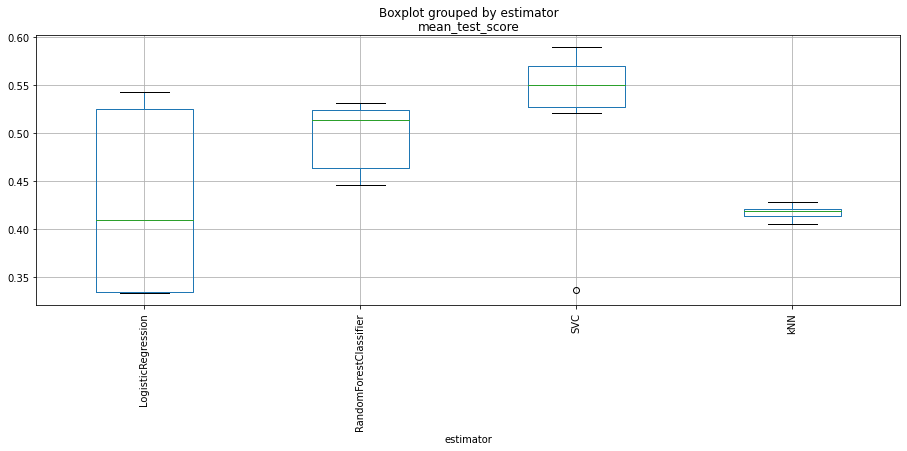

In [27]:
results.boxplot(column='mean_test_score',by='estimator', figsize=(15,5), rot=90)

### 6. ERROR ANALYSIS AND TEST RESULTS

In [28]:
# Predictions for the test set
param = results.loc[0, 'params']
top_model = SVC(**param)
top_model.fit(X_train,y_train)
y_pred = top_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       854
           1       0.64      0.58      0.61       830
           2       0.63      0.57      0.60       816

    accuracy                           0.62      2500
   macro avg       0.63      0.62      0.62      2500
weighted avg       0.63      0.62      0.62      2500



In [29]:
# Label the predictions with their correct name
labels_name = {0:'entailment', 1:'neutral', 2:'contradiction'}
label_pred = [labels_name[i] for i in y_pred] 

# Create a big data frame with the true labels and their predictions
final_df = test_data[['sentence1', 'sentence2', 'gold_label']]
final_df['predictions'] = label_pred 
final_df.head(9)

,sentence1,sentence2,gold_label,predictions
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,contradiction
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,contradiction
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,contradiction
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,entailment
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,neutral
5,"A woman with a green headscarf, blue shirt and...",The woman has been shot.,contradiction,contradiction
6,An old man with a package poses in front of an...,A man poses in front of an ad.,entailment,entailment
7,An old man with a package poses in front of an...,A man poses in front of an ad for beer.,neutral,neutral
8,An old man with a package poses in front of an...,A man walks by an ad.,contradiction,entailment


In [30]:
# Confusion Matrix
from sklearn import metrics

print('Confusion Matrix:')
metrics.confusion_matrix(y_test, y_pred) # Rows = true_labels and Col = predictions

Confusion Matrix:


array([[612, 123, 119],
       [198, 479, 153],
       [197, 151, 468]])

In [31]:
# Compare svm accuracy to the baseline method ('majority class')
baseline_acc = 854/2500
diff = 0.62/baseline_acc
print('Improvement of SVM: ',round(diff,2))

Improvement of SVM:  1.81
